In [14]:
import trimesh

entity='1a1e'
mesh = trimesh.load_mesh('data/PDBbind_v2020_refined/refined-set/'+entity+'/'+entity+'_protein.ply')
print('Number of nodes: ', len(mesh.vertices))
mesh.show()


Number of nodes:  644


In [13]:
mesh.to_dict().keys()

dict_keys(['vertices', 'faces'])

In [2]:
import pymesh
print('Pymesh imported')

Pymesh imported


In [4]:
import py3Dmol
from rdkit import Chem

DATA_PATH = 'data/PDBbind_v2020_refined/refined-set/'
ID = '1a28'
target_ply = DATA_PATH+ID+'/'+ID+'_protein.ply'
real_mol = Chem.MolFromMol2File(DATA_PATH+ID+'/'+ID+'_ligand.mol2',sanitize=False, cleanupSubstructures=False)

p = py3Dmol.view(width=400,height=400)
with open(DATA_PATH+ID+'/'+ID+'_protein.pdb') as ifile:
    target = "".join([x for x in ifile])

p.addModelsAsFrames(target)
p.addModel(Chem.MolToMolBlock(real_mol),'sdf')

tar = {'model':0}
lig_real = {'model':1}

p.setStyle(tar, {'cartoon': {'color':'magenta'}})
# p.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, res)
p.setStyle(lig_real,{'stick':{}})

p.zoomTo()
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
from tqdm import tqdm
import os
from models import read_ply
DATA_PATH = 'data/PDBbind_v2020_refined/refined-set/'
IDs = os.listdir(DATA_PATH)
print('Total protein complexes:', len(IDs))
ply_count=0
for ID in tqdm(IDs[:60]):
    for file_ in os.listdir('%s/%s'%(DATA_PATH, ID)):
        if file_.endswith('.ply'):
            ply_count+=1
            datapoint = read_ply('%s/%s/%s'%(DATA_PATH, ID, file_))
            print(datapoint)
print('Number of ply files', ply_count)
#print(datapoint)

Total protein complexes: 5318


 73%|███████▎  | 44/60 [00:00<00:00, 333.52it/s]

Data(x=[50, 3], pos=[50, 3], face=[3, 82])
Data(x=[485, 3], pos=[485, 3], face=[3, 877])
Data(x=[618, 3], pos=[618, 3], face=[3, 1135])
Data(x=[412, 3], pos=[412, 3], face=[3, 765])
Data(x=[560, 3], pos=[560, 3], face=[3, 1029])
Data(x=[520, 3], pos=[520, 3], face=[3, 932])


100%|██████████| 60/60 [00:00<00:00, 216.98it/s]

Data(x=[676, 3], pos=[676, 3], face=[3, 1261])
Data(x=[589, 3], pos=[589, 3], face=[3, 1116])
Data(x=[146, 3], pos=[146, 3], face=[3, 248])
Number of ply files 9


In [1]:
from torch.distributions import Normal
import torch
from models_orig import LigandNet, TargetNet, AlphaDock, compute_cluster_batch_index, mdn_loss_fn
from torch_geometric.transforms import FaceToEdge, Cartesian
from utils.data import read_ply
from torch_geometric.utils import from_networkx
from utils import mol2graph
from rdkit import Chem

DATA_PATH = '/home/dell4/king/202112_graphDrug/data_v2/PDBbind_v2020_other_PL/v2020-other-PL_minimized/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(3, residual_layers=10, dropout_rate=0.10)
model = AlphaDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

checkpoint = torch.load('DeepDock_pdbbindv2019_13K_minTestLoss.chk', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict']) 

ID = '1a8i'
# GET PROTEIN MESH
target_ply = DATA_PATH+'%s/%s_protein.ply'%(ID, ID)
target_mesh = Cartesian()(FaceToEdge()(read_ply(target_ply)))
# GET MOLECULE NETWORK
real_mol = Chem.MolFromMol2File(DATA_PATH+'%s/%s_ligand.mol2'%(ID, ID),sanitize=False, cleanupSubstructures=False)
mol_ntwk = from_networkx(mol2graph.mol_to_nx(real_mol))

# InFERENCE
pi, sigma, mu, dist, atom_types, bond_types, batch = model(mol_ntwk.to(device), target_mesh.to(device))
target_mesh, mol_ntwk

/home/dell4/miniconda3/envs/gnn_train/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dell4/miniconda3/envs/gnn_train/lib/python3.8/site-packages/torch_geometric/utils/convert.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180544224/work/torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


(Data(x=[417, 128], pos=[417, 3], edge_index=[2, 2400], edge_attr=[2400, 128]),
 Data(x=[17, 128], edge_index=[2, 36], edge_attr=[36, 128], pos=[17, 3]))

In [5]:
target_mesh.x, target_mesh.pos, target_mesh.edge_index, target_mesh.edge_attr

(tensor([[ 0.0384, -0.0466,  0.1667,  ...,  0.0401,  0.0788,  0.0280],
         [ 0.0352, -0.0466, -0.0956,  ...,  0.0528,  0.0882,  0.0280],
         [ 0.0314, -0.0411,  0.0669,  ...,  0.0528,  0.0827,  0.0292],
         ...,
         [ 0.0349, -0.0437, -0.1094,  ...,  0.0528,  0.0688,  0.0276],
         [ 0.0384, -0.0466,  0.1359,  ...,  0.0451,  0.0781,  0.0292],
         [ 0.0384, -0.0434,  0.1745,  ...,  0.0469,  0.0641,  0.0288]],
        device='cuda:0', grad_fn=<EluBackward0>),
 tensor([[31.8645, 27.1250, 29.1480],
         [23.2940, 27.1240, 26.8270],
         [26.0000, 22.9360, 22.7315],
         ...,
         [25.4191, 19.7999, 28.8312],
         [36.2256, 26.4649, 29.9161],
         [27.1693, 25.9652, 22.3364]], device='cuda:0'),
 tensor([[  0,   0,   0,  ..., 416, 416, 416],
         [138, 152, 166,  ..., 199, 309, 399]], device='cuda:0'),
 tensor([[ 3.1725e-42,  3.3827e-42,  3.4780e-42,  ...,  2.3570e-42,
          -2.0124e-03,  2.6176e-42],
         [ 2.3598e-42,  4.0694

In [2]:
pi.shape, sigma.shape, mu.shape, dist.shape, atom_types.shape, bond_types.shape

(torch.Size([7089, 10]),
 torch.Size([7089, 10]),
 torch.Size([7089, 10]),
 torch.Size([7089, 1]),
 torch.Size([17, 28]),
 torch.Size([36, 6]))

In [5]:
dist.shape

torch.Size([7089, 1])

In [3]:
# Loss function 
def mdn_loss_fn(pi, sigma, mu, y):
    normal = Normal(mu, sigma)
    loglik = normal.log_prob(y.expand_as(normal.loc))
    loss = -torch.logsumexp(torch.log(pi) + loglik, dim=1)
    return loss

def calculate_probablity(pi, sigma, mu, y):
    normal = Normal(mu, sigma)
    logprob = normal.log_prob(y.expand_as(normal.loc))
    logprob += torch.log(pi)
    prob = logprob.exp().sum(1)
    return prob

normal = Normal(mu, sigma)
loglik = normal.log_prob(dist.expand_as(normal.loc))
prob = calculate_probablity(pi, sigma, mu, dist)

In [10]:
normal.loc

tensor([[2.4497, 2.4497, 4.7400,  ..., 2.4497, 2.4497, 2.4497],
        [1.6945, 1.6945, 3.1872,  ..., 1.6945, 1.6945, 1.6945],
        [2.6515, 2.6515, 6.2280,  ..., 2.6515, 2.6515, 2.6515],
        ...,
        [2.3832, 2.3832, 5.8056,  ..., 2.3832, 2.3832, 2.3832],
        [2.4272, 2.4272, 4.8126,  ..., 2.4272, 2.4272, 2.4272],
        [2.4314, 2.4315, 5.9605,  ..., 2.4314, 2.4315, 2.4315]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [59]:
torch.log(pi).shape

torch.Size([33348, 10])

In [14]:
def calculate_probablity(pi, sigma, mu, y):
    normal = Normal(mu, sigma)
    logprob = normal.log_prob(y.expand_as(normal.loc))
    logprob += torch.log(pi)
    prob = logprob.exp().sum(1)
    return prob

torch.Size([10])

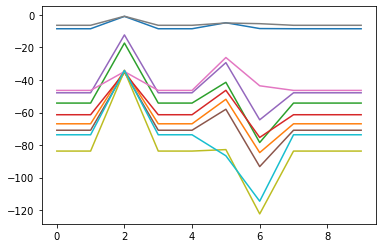

In [6]:
import matplotlib.pyplot as plt
for i in range(len(loglik[400])):
    plt.plot(range(len(loglik[i,:])), loglik[i,:].cpu().detach().numpy())

(0.0, 257.0)

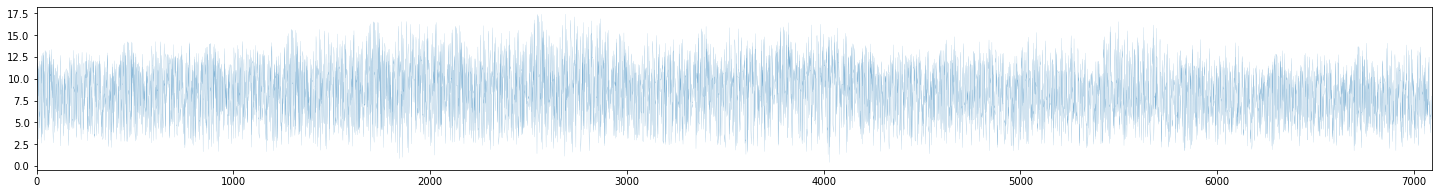

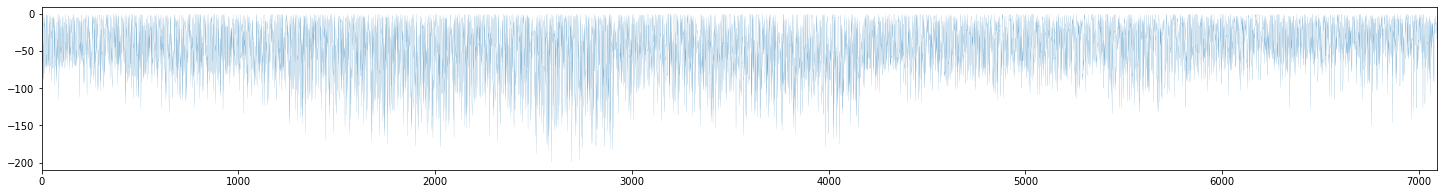

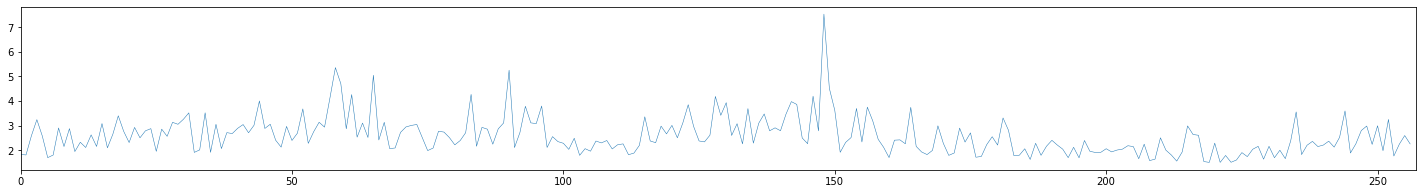

In [5]:
import matplotlib.pyplot as plt

# Plot DIST
fig, ax = plt.subplots(figsize=(25,3))
ax.plot(range(len(dist)), dist.cpu().detach().numpy(), linewidth=0.1)
ax.set_xlim(0, len(dist))  

# Plot LogLik
fig, ax = plt.subplots(figsize=(25,3))
ax.plot(range(len(loglik[:, 1])), loglik[:, 0].cpu().detach().numpy(), linewidth=0.1)
ax.set_xlim(0, len(loglik[:, 1]))

# Plot MDN
model.dist_threhold = 3.0
mdn = mdn_loss_fn(pi, sigma, mu, dist)
mdn = mdn[torch.where(dist <= model.dist_threhold)[0]]
fig, ax = plt.subplots(figsize=(25,3))
ax.plot(range(len(mdn)), mdn.cpu().detach().numpy(), linewidth=0.5)
ax.set_xlim(0, len(mdn))

In [70]:
# Save data in {ligand, target, activity, pdbid} format
from tqdm import tqdm, tnrange
from linecache import getline
import pandas as pd

unit = []
metric = []
net_activity = []
from tqdm import tqdm
import collections
for i in tqdm(range(5000)):
    try:
        line = getline('data/PDBbind_v2020_refined/refined-set/index/INDEX_refined_set.2020',i)
        activity=line.split(' ')[6]
        unit.append(activity[-2:])
        metric.append(activity[:2])
        if activity.endswith('nM'):
            activity=float(activity.split('=')[1][:-2])/1000
            net_activity.append(activity)
        elif activity.endswith('uM'):
            activity=float(activity.split('=')[1][:-2])
            net_activity.append(activity)
        elif activity.endswith('mM'):
            activity=float(activity.split('=')[1][:-2])*1000
            net_activity.append(activity)
        elif activity.endswith('pM'):
            #activity=float(activity.split('=')[1][:-2])
            pass
    except:
        pass

print(collections.Counter(unit))
print(collections.Counter(metric))

100%|██████████| 5000/5000 [00:00<00:00, 234683.14it/s]

Counter({'uM': 2467, 'nM': 2101, 'mM': 281, 'pM': 132, '': 11, 'he': 1, 'ed': 1, 'ng': 1, 'fM': 1})
Counter({'Kd': 2584, 'Ki': 2398, '': 11, 'th': 1, 'so': 1, 'bi': 1})


MAX: 10100.0
MIN: 1.2e-06
MEAN: 162.22792914027636
MEDIAN: 0.4


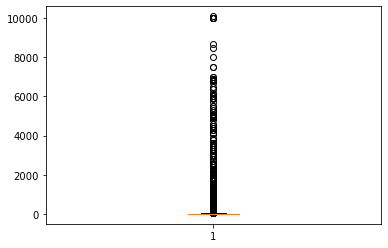

In [71]:
import matplotlib.pyplot as plt
import numpy as np

plt.boxplot(net_activity)

print('MAX:', np.max(net_activity))
print('MIN:', np.min(net_activity))
print('MEAN:', np.mean(net_activity))
print('MEDIAN:', np.median(net_activity))

MAX: 220000000.0
MIN: 2e-06
MEAN: 148343.70404118477
MEDIAN: 77.0


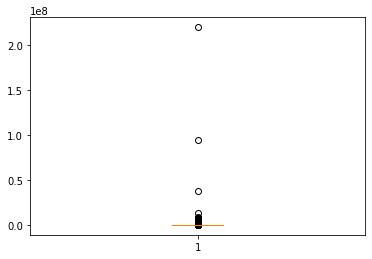

In [69]:
import matplotlib.pyplot as plt
import numpy as np

plt.boxplot(net_activity)

print('MAX:', np.max(net_activity))
print('MIN:', np.min(net_activity))
print('MEAN:', np.mean(net_activity))
print('MEDIAN:', np.median(net_activity))

In [23]:
if activity.endswith('nM'):
    print(activity.split('=')[1][:-2])
elif activity.endswith('uM'):
    print(activity.split('=')[1][:-2])
elif activity.endswith('mM'):
    print(activity.split('=')[1][:-2])
elif activity.endswith('pM'):
    print(activity.split('=')[1][:-2])

0.068


In [15]:
activity

'Ki=0.068nM'

In [21]:
import networkx as nx
import pptk
v = pptk.viewer(datapoint)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.